C:\Users\10075\AppData\Local\Temp\ipykernel_6932\2858004446.py:11: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


XGBoost 最佳参数: {'subsample': 0.9, 'n_estimators': 5000, 'max_depth': 3, 'colsample_bytree': 0.9}
XGBoost - 计算均方误差 (MSE): 188895397026.4531
XGBoost - 计算决定系数 (R²): 0.9994930612121727


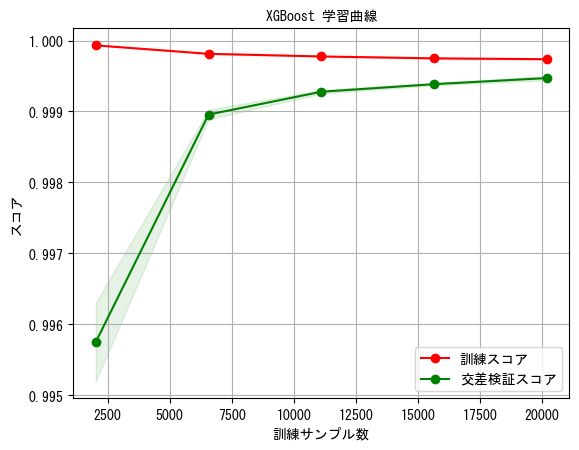

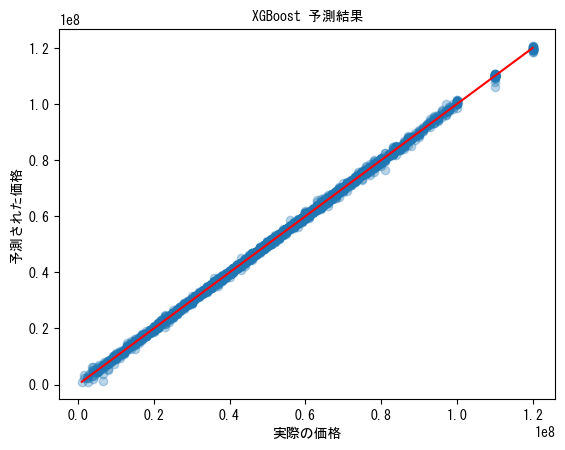

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 加载数据集
file_path = 'E:\\AI\\0705fix Tokyo house price.csv'
df = pd.read_csv(file_path)

# 设置日文字体为Windows系统自带的MS Gothic字体
plt.rcParams['font.sans-serif'] = ['MS Gothic']
plt.rcParams['axes.unicode_minus'] = False

# 筛选出'取引時期'列中包含2018年至2023年的数据
df['取引時期'] = df['取引時期'].astype(str)  # 将'取引時期'列转换为字符串类型
filtered_df = df[df['取引時期'].str.contains(r'202[0-3]|201[8-9]', regex=True)]  # 筛选包含2018至2023年的数据
filtered_df = filtered_df.query('種類 == "宅地(土地と建物)"')  # 筛选出'種類'列等于"宅地(土地と建物)"的行
filtered_df = filtered_df.query('今後の利用目的 == "住宅"')  # 筛选出'今後の利用目的'列等于"住宅"的行

# 选择相关的特征列
selected_columns = ['区の平均世帯年収:円', '価格相場：円', '家賃相場：円', '最寄駅：距離（分）', '取引価格（総額）', '面積（㎡）', 
                    '取引価格（㎡単価）', '間口', '延床面積（㎡）', '建築年', '築年数', '建物の構造評価', '方位評価', 
                    '前面道路：幅員（ｍ）', '建ぺい率（％）', '容積率（％）']
selected_df = filtered_df[selected_columns]  # 筛选出需要的列

# 数据清洗步骤

# 转换为数值类型
selected_df = selected_df.apply(pd.to_numeric, errors='coerce')

# 处理缺失值
selected_df.fillna(selected_df.median(), inplace=True)  # 用中位数填补缺失值

# 计算IQR并过滤异常值
Q1 = selected_df.quantile(0.25)  # 计算第1四分位数
Q3 = selected_df.quantile(0.75)  # 计算第3四分位数
IQR = Q3 - Q1  # 计算四分位距
is_outlier = (selected_df < (Q1 - 1.5 * IQR)) | (selected_df > (Q3 + 1.5 * IQR))  # 标记异常值
data_cleaned = selected_df[~is_outlier.any(axis=1)]  # 去除异常值

# 数据预处理
X = data_cleaned.drop('取引価格（総額）', axis=1)  # 特征数据
y = data_cleaned['取引価格（総額）']  # 目标数据

# 划分数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 特征标准化
scaler = StandardScaler()  # 初始化标准化器
X_train = scaler.fit_transform(X_train)  # 标准化训练集特征
X_test = scaler.transform(X_test)  # 标准化测试集特征

# 定义XGBoost模型和参数
xgb_model = XGBRegressor(objective='reg:squarederror', learning_rate=0.05, verbosity=2, random_state=42)

params = {
    'n_estimators': [1000, 2000, 3000, 4000, 5000],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# 进行随机搜索和交叉验证
random_search = RandomizedSearchCV(xgb_model, params, n_iter=100, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)
best_xgb_model = random_search.best_estimator_
print(f'XGBoost 最佳参数: {random_search.best_params_}')

# 训练最佳模型
best_xgb_model.fit(X_train, y_train)

# 可视化学习曲线的函数
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title, fontproperties='MS Gothic')  # 设置标题
    plt.xlabel("訓練サンプル数", fontproperties='MS Gothic')  # 设置x轴标签
    plt.ylabel("スコア", fontproperties='MS Gothic')  # 设置y轴标签
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)  # 计算训练得分的平均值
    train_scores_std = np.std(train_scores, axis=1)  # 计算训练得分的标准差
    test_scores_mean = np.mean(test_scores, axis=1)  # 计算测试得分的平均值
    test_scores_std = np.std(test_scores, axis=1)  # 计算测试得分的标准差
    plt.grid()  # 显示网格

    # 绘制学习曲线
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="訓練スコア")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="交差検証スコア")

    plt.legend(loc="best")  # 显示图例
    return plt

# 绘制XGBoost模型的学习曲线
plot_learning_curve(best_xgb_model, 'XGBoost 学習曲線', X_train, y_train)

# 评估模型的性能并进行可视化
y_pred = best_xgb_model.predict(X_test)  # 预测测试集
mse = mean_squared_error(y_test, y_pred)  # 计算均方误差
r2 = r2_score(y_test, y_pred)  # 计算决定系数
print(f'XGBoost - 计算均方误差 (MSE): {mse}')
print(f'XGBoost - 计算决定系数 (R²): {r2}')

plt.figure()
plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("実際の価格", fontproperties='MS Gothic')
plt.ylabel("予測された価格", fontproperties='MS Gothic')
plt.title('XGBoost 予測結果', fontproperties='MS Gothic')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
plt.show()
